In [318]:
# IMPORTS

#---------------------------------------
import numpy as np
from matplotlib import pyplot as plt
from astropy import constants as astro_const

import copy # To copy multidimensional arrays
from scipy import signal # Data analysis

#---------------------------------------------
# Animation libraries
import os
import imageio

In [319]:
# INPUT READING FUNCTIONS

#---------------------------------------------
# Read the input file:
#
# N = number of particles
# t_0 = initial time
# particles_0 = collection of mass + 6D position/velocity vector for every particle in the system
# The shape of particles is: [[m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1], 
#                             [m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2],
#                             ...,
#                             [m_N x_N, y_N, z_N, vx_N, vy_N, vz_N]]
#
# Returns:
#         N
#         a snapshot ("snapshot_0") of the system at the initial condition in the shape:
#         [N, t_0, particles_0] :   [N, t_0, [[m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1], 
#                                             [m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2],
#                                             ...,
#                                             [m_N x_N, y_N, z_N, vx_N, vy_N, vz_N]]]
#
# Input file is structured as follow:
#
# N
# t_0
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
def read_input(input_file_path):
    input_file = open(input_file_path)

    # readline() reads the first line and returns it as a string
    N = int(input_file.readline())
    t_0 = float(input_file.readline())

    # readlines() reads all the remaining lines and returns them into a list of strings
    particles_0 = input_file.readlines()

    input_file.close()

    # Convert the list of strings into a list of lists of number
    for i in range(len(particles_0)):
        # split() splits a string based on a separator (default is ' ') and returns a list of strings
        particles_0[i] = particles_0[i].split()

        # Convert the elements of each splitted string into numbers
        for j in range(len(particles_0[i])):
            particles_0[i][j] = float(particles_0[i][j])

    snapshot_0 = [N, t_0, particles_0]

    return snapshot_0

#-----------------------------------------------------------------------------
# Read the output file:
# # Output file is structured as follow:
#
# N
# t_1
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
# N
# t_2
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
#
# ...
#
# N
# t_f
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
#
# Returns a list of snapshot of the evolved system (t>t_0)
# See read_input for details on the snapshots
def read_output(output_file_path):
    output_file = open(output_file_path)

    # List to store all the snapshots in the output file
    snapshots = []

    # Try except here detects the EOF
    # int() throws an exception when tries to convert something different than a number
    while True:
        try:
            N = int(output_file.readline())
        except:
            break

        # Line after N is the time stamp of the snapshot
        t_stamp = float(output_file.readline())

        # Collect strings of mass + 6D position/velocity vector N times (for N particles)
        particles = [output_file.readline() for i in range (N)]

        # Convert the list of strings into a list of lists of number (same as for read_input())
        for i in range(len(particles)):
            particles[i] = particles[i].split()

            for j in range(len(particles[i])):
                particles[i][j] = float(particles[i][j])
        
        # Append the snapshot [t_stamp, particles] to the snapshots list
        snapshots.append([N, t_stamp, particles])

    output_file.close()
    
    return snapshots

#--------------------------------------------------------------------------
# Returns:
#         N
#         The complete list of snapshots of the system (including the initial one)
#
# How to navigate the snapshots:
# 1) Choose the snapshot:
#    *** snapshots[snapshot_index, from 0 to len(snapshot)-1] ***
#
# 2) What do you want?
#    A) Number of particles:
#       *** snapshot[snapshot_index][0] ***
#       Note that snapshot[snapshot_index][0] can't be subscripted anymore
#
#    B) Time stamp: 
#       *** snapshot[snapshot_index][1] ***
#       Note that snapshot[snapshot_index][1] can't be subscripted anymore
#
#    C) Particles masses, positions and velocities:
#       *** snapshot[snapshot_index][2] ***
#       This is a list of lists (see read_input() for details)
#
# 3) Which particle are you interested in?
#    *** snapshot[snapshot_index][2][particle_index, from 0 to N-1] ***
#
# 4) What do you want to know about the particle:
#    *** Mass: snapshot[snapshot_index][2][particle_index][0] ***
#    *** x, y, z: snapshot[snapshot_index][2][particle_index][1, 2, 3] ***
#    *** vx, vy, vz: snapshot[snapshot_index][2][particle_index][1+3, 2+3, 3+3] ***
def read_snapshots(input_file_path, output_file_path):
    snapshot_0 = read_input(input_file_path)
    snapshots = read_output(output_file_path)

    # Append the intial snapshot to the beginning of the list
    snapshots = [snapshot_0] + snapshots

    return snapshots

In [320]:
# MATHEMATICAL FUNCTIONS

#-------------------------------------------------------------------------
# Returns the difference between two vectors (vector_2 - vector_1)
# 
# If vectors are positions:
# It is a vector that points from position_1 to position_2: [x_2 - x_1, y_2 - y_1, z_2 - z_1]
# 
# If vectors are velocities:
# It is a vectors that describes the relative velocity in the frame in which particle 1 is at rest
# [vx_2 - vx_1, vy_2 - vy_1, vz_2 - vz_1]
#
# Imput parameters are strictly numpy arrays of 3 numbers: (x, y, z)
def compute_vector_diff(vector_1, vector_2):
    return vector_2 - vector_1

# Returns the vectorial product of two vectors
# Imput parameters are strictly numpy arrays of 3 numbers: (x, y, z)
def compute_vectorial_product(vector_1, vector_2):
    x = vector_1[1] * vector_2[2] - vector_1[2] * vector_2[1]
    y = vector_1[2] * vector_2[0] - vector_1[0] * vector_2[2]
    z = vector_1[0] * vector_2[1] - vector_1[1] * vector_2[0]

    return np.array([x, y, z])

# Returns the absolute value of a vector to the absval-th power
def compute_vector_abs(vector, absval=1):
    value = 0

    for i in range(len(vector)):
        value += vector[i] ** 2
    
    # Don't waste computational power if you want the square of the vector
    if absval == 2:
        pass
    else:
        value = value ** (absval / 2)

    return value

# Returns the distance between two points
# Imput parameters are arrays of 3 numbers: (x, y, z)
def compute_distance(point_1, point_2):
    distance = 0
    for i in range (3):
        distance += (point_1[i] - point_2[i]) ** 2
    
    return distance ** (1 / 2)

In [321]:
# COORDINATES FUNCTIONS

#----------------------------------------------------------------
# Returns the 3D vector (x, y, z) correspoding to the spherical_coordinates (r, theta, phi)
# Imput parameter is strictly a numpy array of 3 numbers: (r, theta, phi)
def spherical_to_cartesian(spherical_coordinates):
    r = spherical_coordinates[0]
    theta = spherical_coordinates[1]
    phi = spherical_coordinates[2]

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    # Floating point precision would not give exact results around zeros of goniometric functions
    return np.array([x, y, z])

# Returns the 3D vector (r, theta, phi) correspoding to the cartesian_coordinates (x, y, z)
# Imput parameter is strictly a numpy array of 3 numbers: (x, y, z)
def cartesian_to_spherical(cartesian_coordinates):
    x = cartesian_coordinates[0]
    y = cartesian_coordinates[1]
    z = cartesian_coordinates[2]

    r = ((x ** 2) + (y ** 2) + (z ** 2)) ** (1 / 2)

    if x == 0 and y == 0 and z == 0:
        theta = None
    else:
        theta = np.arccos(z / r)

    if x == 0 and y == 0:
        phi = None
    else:
        phi = np.arccos(x / (r * np.sin(theta)))
        if y < 0:
            phi = 2 * np.pi - phi
    
    # Floating point precision would not give exact results around zeros of goniometric functions
    return np.array([r, theta, phi])

In [322]:
# SNAPSHOTS READING FUNCTIONS & SMALL CALCULATIONS

#------------------------------------------------------------------
# Returns an array of the number of particles of the snapshots
def get_N(snapshots):
    return np.array([snapshots[i][0] for i in range(len(snapshots))])

# Returns an array of the time stamps of the snapshots
def get_timestamps(snapshots):
    return np.array([snapshots[i][1] for i in range(len(snapshots))])

# Returns an array of the masses at the specified time
# If total=True returns the total mass
def get_masses(snapshots, total=False, time_index=0):
    if not total:
        masses = np.array([snapshots[time_index][2][i][0]
                           for i in range(len(snapshots[time_index][2]))])
    elif total:
        masses = np.sum([snapshots[time_index][2][i][0]
                         for i in range(len(snapshots[time_index][2]))])
        
    return masses

# Compute the position or velocity of the center of mass for the specified snapshot
# Returns an array of 3 values: [qt_x, qt_y, qt_z]
# vec = 'pos', 'vel'
def get_center_of_mass(snapshots, time_index, vec=''):
    M_tot = get_masses(snapshots, total=True, time_index=time_index)
    qtX_CM, qtY_CM, qtZ_CM = 0, 0, 0

    if vec.lower() == 'pos':
        shift = 0
    elif vec.lower() == 'vel':
        shift = 3

    for i in range(snapshots[time_index][0]):
        qtX_CM += snapshots[time_index][2][i][0] * snapshots[time_index][2][i][1+shift]
        qtY_CM += snapshots[time_index][2][i][0] * snapshots[time_index][2][i][2+shift]
        qtZ_CM += snapshots[time_index][2][i][0] * snapshots[time_index][2][i][3+shift]
    
    qtX_CM /= M_tot
    qtY_CM /= M_tot
    qtZ_CM /= M_tot

    return np.array([qtX_CM, qtY_CM, qtZ_CM])

# absval = 0: returns an array of 3D vectors of the specified particle, for the specified quantity
#             in the specified reference frame
# [[Qx1_0, Qy_0, Qz_0], [Qx_1, Qy_1, Qz_1], ..., [len(snapshots)-1]]
# absval = n != 0: returns the absolute value of the vectors to the absval-th power
# vec = 'pos', 'vel'
# rf = 'snapshot', 'cm' (center of mass), 'particle' (specify which particle with the next parameter)
# if time_index is an integer, only the vector corresponding to that time is returned
def get_3D_vec(snapshots, particle_index, vec='', absval=0, rf='snapshot',
               rf_particle_index=None, time_index=None):
    if vec.lower() == 'pos':
        shift = 0
    elif vec.lower() == 'vel':
        shift = 3
    
    # Define parameters for range() calls
    start_time = 0
    stop_time = len(snapshots)
    step = 1

    # If time_index is specified then modify the parameters in order to get just that time
    if type(time_index) == int:
        start_time = time_index
        step = stop_time

    # Compute in the snapshot reference frame
    if rf.lower() == 'snapshot':
        result = np.array([snapshots[i][2][particle_index][1+shift:4+shift]
                           for i in range(start_time, stop_time, step)])
    
    # Compute in the center of mass reference frame
    elif rf.lower() == 'cm':
        result = compute_vector_diff(np.array([get_center_of_mass(snapshots, i, vec)
                                               for i in range(start_time, stop_time, step)]),
                                               np.array([snapshots[i][2][particle_index][1+shift:4+shift]
                                                         for i in range(start_time, stop_time, step)]))
    
    # Compute in the reference frame of the specified particle
    elif rf.lower() == 'particle':
        result = compute_vector_diff(np.array([snapshots[i][2][rf_particle_index][1+shift:4+shift]
                                               for i in range(len(snapshots))]),
                                               np.array([snapshots[i][2][particle_index][1+shift:4+shift]
                                                         for i in range(start_time, stop_time, step)]))
    
    # Return the result as it is
    if absval == 0:
        pass
    
    # Compute the absval-th power of every vector into "result"
    elif absval != 0:
        for i in range(len(result)):
            result[i] = compute_vector_abs(result[i], absval)

        # Because of how numpy arrays works, we need to slice the array to take the first column
        # Actually any column would be fine because now their content is equal
        # The point is that we want just one set of values and not three
        result = result[:, :1]

        # Slicing returns an array with shape [[x_0], [x_1], ..., [x_(len(snapshot)-1)]]
        # Redefine the array to get rid of the 1-element lists
        result = np.array([result[i][0] for i in range(len(result))])

    # If time index is specifed then the time axis at this point would have dimension 1
    # Subscript "result" in order to get rid of the 1-sized axis
    if type(time_index) == int:
        result = result[0]

    return result

# Returns an array of the specified coordinate for the specified particle for the specified quantity
# in the specified reference frame
# vec = 'pos', 'vel'
# axe = 'x', 'y', 'z'
# rf = 'snapshot', 'cm' (center of mass), 'particle' (specify which particle with the next parameter)
# if time_index is an integer, only the specified coordinate corresponding to that time is returned
def get_coord(snapshots, particle_index, vec='', axe='', rf='snapshot',
              rf_particle_index=None, time_index=None):
    # coordinates works like this: coordinates[time_index][axe_index]
    # coordinates[0] returns the 3D vector of the particle at t_0
    coordinates = get_3D_vec(snapshots, particle_index, vec, rf=rf,
                             rf_particle_index=rf_particle_index, time_index=time_index)

    # Swap the axis to obtain coordinates[axe_index][time_index]
    # coordinates[1] returns all the 'y' components of the particle vector at every time
    # Do this only if time_index has not been specified
    # If time_index has been specified then coordinates have already shape [x, y, z]
    # for the specified particle at the specified time
    if type(time_index) != int:
        coordinates = np.swapaxes(coordinates, 0, 1)

    if axe.lower() == 'x':
        coordinates = coordinates[0]
    elif axe.lower() == 'y':
        coordinates = coordinates[1]
    elif axe.lower() == 'z':
        coordinates = coordinates[2]

    return coordinates

In [323]:
# PHYSICS FUNCTIONS

#-------------------------------------------------------------------------
# Returns the energy of the system for the specified snapshot in the specified reference frame
# E_type = 'kin', 'pot', 'tot', 'all'. If 'all', returns an ordered tuple: (E_kin, E_pot, E_tot)
# rf = 'snapshot', 'cm' (center of mass)
# E_parts_kin and E_parts_pot are numpy arrays passed to the fucntion that can be modified
# This is exactly because they are arrays and the function will read their memory addresses
# They will be modified only if they have the right shape: E_parts_kin: (N, )
#                                                          E_parts_pot: (N, N)
# Where N is the number of particles
#
# *** ABOUT E_parts ***
#
# E_parts_kin is a collection of the kinetic energies of every particle at the specified time
# It works like this: E_parts_kin[particle_index]
#
# E_parts_pot is a collection of the potential energies of every particle
# with all other particles at the specified time
# It works like this: E_parts_pot[particle_index][particle_index]
# Self energies are set to zero: E_parts_pot[i][j] = 0 if i = j
# Note that if you want the total potential energy at a given time you can sum all the contents of 
# E_parts_pot but you have to divide by 2 at the end because it is a symmetric matrix
def get_energy(snapshots, time_index, E_type='', rf='snapshot', rf_particle_index=None,
               E_parts_kin=None, E_parts_pot=None):
    N = snapshots[time_index][0]

    if E_type.lower() == 'kin':
        E = 0
        
        # A list of lists of the velocities squared of every mass at the specified time
        # [v_0_time_index, v_1_time_index, v_2_time_index, ..., v_(N-1)_time_index]
        v_squared = [get_3D_vec(snapshots, particle_index, 'vel', 2, rf, rf_particle_index, time_index)
                     for particle_index in range (N)]

        for i in range(N):
            value = (1 / 2) * snapshots[time_index][2][i][0] * v_squared[i]
            E += value
            # If requested save the individual kinetic energy
            if type(E_parts_kin) == np.ndarray and E_parts_kin.shape == (N, ):
                E_parts_kin[i] = value
    elif E_type.lower() == 'pot':
        E = 0
        # Same as above but it's for position vectors
        # positions[i] is the 3D vector of the i-th particle at specified time
        # Note that since we need just the relative distances between particles, it is not
        # necessary to compute the positions in a reference frame different from 'snapshot'
        # Infact relative distances are frame independent
        # This solution is preferable because more computationally efficient
        positions = [get_3D_vec(snapshots, particle_index, 'pos', rf='snapshot', time_index=time_index)
                     for particle_index in range(N)]

        # Cycle over all possible combination of particles
        # part_0: part_1, part_2, part_3, ..., part_(N-1)
        # part_1: part_2, part_3, part_4, ..., part_(N-1)
        # part_2: part_3, part_4, part_5, ..., part_(N-1)
        # ...
        # part_i: part_(i+1), part_(i+2), ..., part_(N-1)
        for i in range(N):
            for j in range(i+1, N):
                distance = compute_distance(positions[i], positions[j])
                value = -1 * snapshots[time_index][2][i][0] * snapshots[time_index][2][j][0] / distance
                E += value
                # If requested save the individual potential energy interaction
                # Build up a symmetric matrix
                if type(E_parts_pot) == np.ndarray and E_parts_pot.shape == (N, N):
                    E_parts_pot[i][j] = value
                    E_parts_pot[j][i] = value
    elif E_type.lower() == 'tot':
        E_kin = get_energy(snapshots, time_index, 'kin', rf, rf_particle_index, E_parts_kin, E_parts_pot)
        E_pot = get_energy(snapshots, time_index, 'pot', rf, rf_particle_index, E_parts_kin, E_parts_pot)
        E = E_kin + E_pot

    elif E_type.lower() == 'all':
        E_kin = get_energy(snapshots, time_index, 'kin', rf, rf_particle_index, E_parts_kin, E_parts_pot)
        E_pot = get_energy(snapshots, time_index, 'pot', rf, rf_particle_index, E_parts_kin, E_parts_pot)
        E = E_kin + E_pot

        E = E_kin, E_pot, E

    return E

In [324]:
# PROBLEM SPECIFIC FUNCTIONS

#-------------------------------------------------
def get_sphere_volume(radius):
    return (4 * np.pi / 3) * radius ** 3

def get_collapse_time(density): # G = 1
    T_w = (3 * np.pi / density) ** (1 / 2)
    return T_w / (4 * 2 ** (1 / 2))

In [325]:
# GLOBAL VARIABLES

#---------------------------------------------
# Relevant constants in CGS
G = astro_const.G.cgs
M_sun = astro_const.M_sun.cgs
kpc = astro_const.kpc.cgs

# Internal units conversion factors: G = 1, M = 1 M_sun, r = 1 kpc
v_I_to_v_cgs = (G * M_sun / kpc) ** (1 / 2)
t_I_to_t_cgs = kpc / v_I_to_v_cgs

# Strings for units
mass_unit_str = "$M_\odot$"
distance_unit_str = "$kpc$"

# Printing conversion factors
print(v_I_to_v_cgs)
print(t_I_to_t_cgs)

207.38652969844205 cm / s
1.4878871766542453e+19 s


In [326]:
# FILE READING

#----------------------------------------------------------------
input_file_path = "input_5.txt"
output_file_path = "output_5_1.txt"

snapshots = read_snapshots(input_file_path, output_file_path)

N = snapshots[0][0] # Number of particles

# "pos" works like this: pos[particle_index][time_index][coordinate_index]
pos = np.array([get_3D_vec(snapshots, particle_index, 'pos', rf='snapshot') for particle_index in range(N)])

# "cm_pos" works like this: cm_pos[time_index][coordinate_index]
cm_pos = np.array([get_center_of_mass(snapshots, time_index, 'pos') for time_index in range(len(snapshots))])

time_stamp = get_timestamps(snapshots)

In [327]:
# ENERGY

#----------------------------------------------------
# Initialize a dictionary for the energy
# Each key, 'kin', 'pot', 'tot', will contain an array of values describing the corresponding
# energy for every time stamp. Example: Energy['kin'] = [E_kin_0, E_kin_1, ..., E_kin_(len(snapshot)-1)]
Energy = {}
Energy_keys = ['kin', 'pot', 'tot']

# Initialise correctly shaped arrays to store the individual values
# of the kinetic and potential energy during the calculation
# Their time axes (axes 0) entries will be modified by get_energy() when passed as parameters
# See get_energy() for details

# It works likw this: particles_E_kin[time_index][particle_index]
particles_E_kin = np.zeros((len(snapshots), N))
# It works likw this: particles_E_pot[time_index][particle_index][particle_index]
particles_E_pot = np.zeros((len(snapshots), N, N))

# Get all the energies for every snapshot. See get_energy() for details.
# "en" works like this: en[time_index][energy_type], where energy_type = 0, 1, 2 ('kin', 'pot', 'tot')
en = np.array([get_energy(snapshots, time_index, 'all', rf='cm',
                          E_parts_kin=particles_E_kin[time_index],
                          E_parts_pot=particles_E_pot[time_index])
                          for time_index in range(len(snapshots))])

# Swap the axis to obtain en[energy_type][time_index]
# So writing en[0] will return an array containing the kinetic energy of the system at every time
en = np.swapaxes(en, 0, 1)

# Store the results in the dictionary
Energy['kin'] = en[0]
Energy['pot'] = en[1]
Energy['tot'] = en[2]

del en # This is not needed

# Compute the relative energy error
Energy_rel_e = (Energy['tot'] - Energy['tot'][0]) / Energy['tot'][0]

In [328]:
# Initialise a list to store the generated figures 
figures = []

# Initialise a list to store their names
figures_names = []

'kin' Collpase time = 0.0485138261184247
'pot' Collpase time = 0.0485138261184247


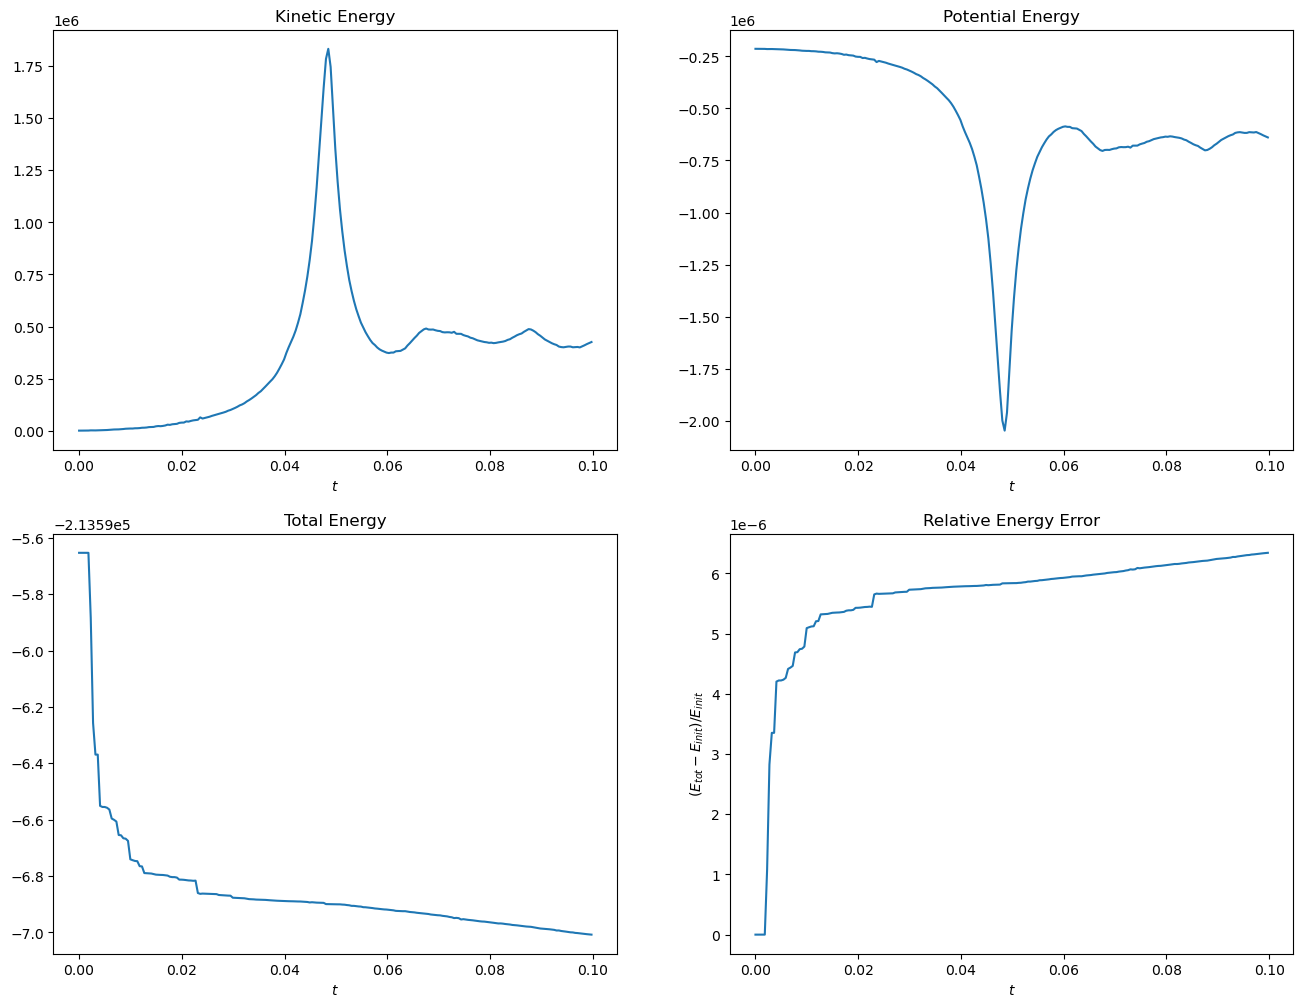

In [329]:
# ENERGY PLOTS

#----------------------------------------------------------------------
# These are ordered to match the Energy_keys
title_labels = ["Kinetic Energy", "Potential Energy", "Total Energy"]

n_rows = 2
n_col = 2

fig, ax = plt.subplots(n_rows, n_col, figsize=(16,12))

index = 0 # Index to count cycles and break
for i in range(n_rows):
    for j in range(n_col):
        ax[i][j].set_title(title_labels[index])
        ax[i][j].plot(time_stamp, Energy[Energy_keys[index]])
        ax[i][j].set_xlabel("$t$")

        index +=1
        if index == 3:
            break

ax[1][1].set_title("Relative Energy Error")
ax[1][1].plot(time_stamp, Energy_rel_e)
ax[1][1].set_xlabel("$t$")
ax[1][1].set_ylabel("$(E_{tot}-E_{init})/E_{init}$")

collapse_index = np.argmax(Energy['kin'])
print("'kin' Collpase time = " + str(time_stamp[collapse_index]))

collapse_index = np.argmin(Energy['pot'])
print("'pot' Collpase time = " + str(time_stamp[collapse_index]))

figures.append(fig)
figures_names.append("energy")

plt.show()

In [330]:
# TOTAL ENERGY OF EACH PARTICLE

#----------------------------------------------------
# Initialize an array for the total energy of every particle at every time
# It works like this: particle_E_tot[time_index][particle_index]
particle_E_tot = np.zeros((len(snapshots), N))

for time_index in range(len(snapshots)): # Pick a certain time
    for i in range(N): # Pick a certain particle
        # Add its kinetic energy
        particle_E_tot[time_index][i] += particles_E_kin[time_index][i]
        # Add all its gravitational interactions with all other particles
        # particles_E_pot[time_index][i] contains all the interactions of particle i
        # at the psecified time. Just sum them all
        # Using np.sum() is much more computationally efficient than cycling over another time
        particle_E_tot[time_index][i] += np.sum(particles_E_pot[time_index][i])
        
# Create a mask that tells if, at any time, any particle is bounded
is_particle_bounded = particle_E_tot < 0

# Count how many particles are bounded at any time
negative_E_tot_particles = np.sum(is_particle_bounded, axis=1)

In [331]:
# PARTICLES INSIDE BOUNDARY

#------------------------------------------------------
# We want to count how many particles stay inside the sphere defined by the
# furthermost particle from the center of mass at the intial time
# particle_distance_cm works like this: particle_distance_cm[particle_index][time_index]
particles_distance_cm = np.array([get_3D_vec(snapshots, particle_index, 'pos', absval=1, rf='cm')
                                  for particle_index in range(N)])

# Swap the axis in order to have particle_distance_cm[time_index][particle_index]
particles_distance_cm = np.swapaxes(particles_distance_cm, 0, 1)

In [332]:
# Get the maximum distance from the center of mass at the initial time
boundary = np.max(particles_distance_cm[0])

# Create a mask that tells if, at any time, any particle is inside the boundary
is_particle_inside_boundary = particles_distance_cm <= boundary

# Count how many particles are inside the boundary at any time
particles_inside_boundary = np.sum(is_particle_inside_boundary, axis=1)

In [333]:
# FIRST KINETIC ENERGY MAXIMUM AFTER COLLAPSE

#--------------------------------------------------------------------
# We want to search for the first local maximum of the kinetic energy after the collapse time
# But we want to neglect too small fluctuations

# agrelmax() searches for maximum in a given signal
# "order" parameter tells the function how wide should be (at least) the maximum peak
# It should be adjusted manually if required
# The first subscript is there because the function returns a tuple of arrays even in the 1D case
first_kin_max_index = signal.argrelmax(Energy['kin'], order=5)[0]

# Now mask every index lower than the collapse time index and select the first element of the outcome
first_kin_max_index = first_kin_max_index[first_kin_max_index>collapse_index][0]

Particles inside the boundary at the first kinetic energy local maximum = 88.0 %


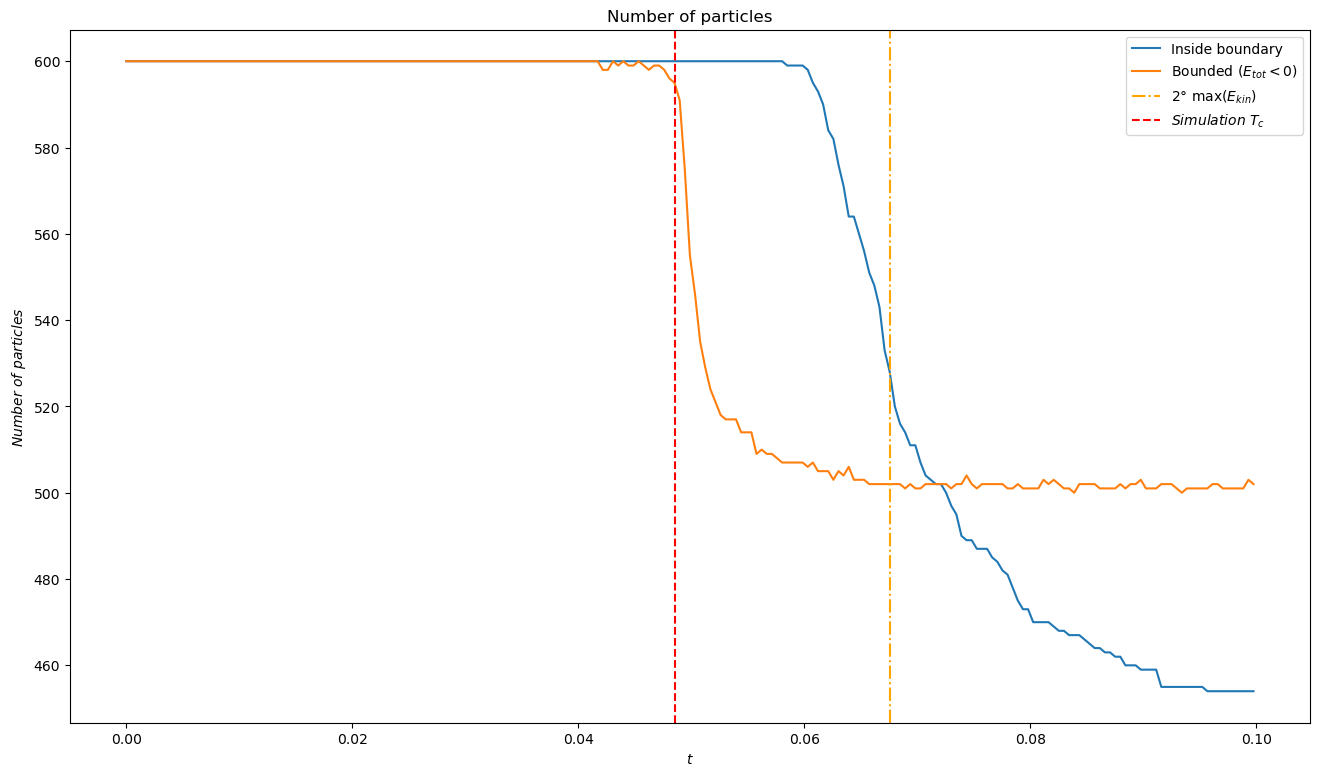

In [334]:
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Number of particles")
ax.set_xlabel("$t$")
ax.set_ylabel("$Number\ of\ particles$")

ax.plot(time_stamp, particles_inside_boundary, label='Inside boundary')
ax.plot(time_stamp, negative_E_tot_particles, label='Bounded ($E_{tot}<0$)')
ax.axvline(time_stamp[first_kin_max_index], color='orange', ls='-.', label='$2°\ \max(E_{kin})$')
ax.axvline(time_stamp[collapse_index], color='red', ls='--', label='$Simulation\ T_c$')

ax.legend()

percentage_inside_boundary = 100 * (particles_inside_boundary[first_kin_max_index] /
                                    particles_inside_boundary[0])

print("Particles inside the boundary at the first kinetic energy local maximum = " +
      str(round(percentage_inside_boundary, 2)) + " %")

figures.append(fig)
figures_names.append("particles")

plt.show()

Expected Collapse time = 0.04718700849315616
Simulation Collpase time = 0.0485138261184247
Relative Error = 2.8118282290791465 %


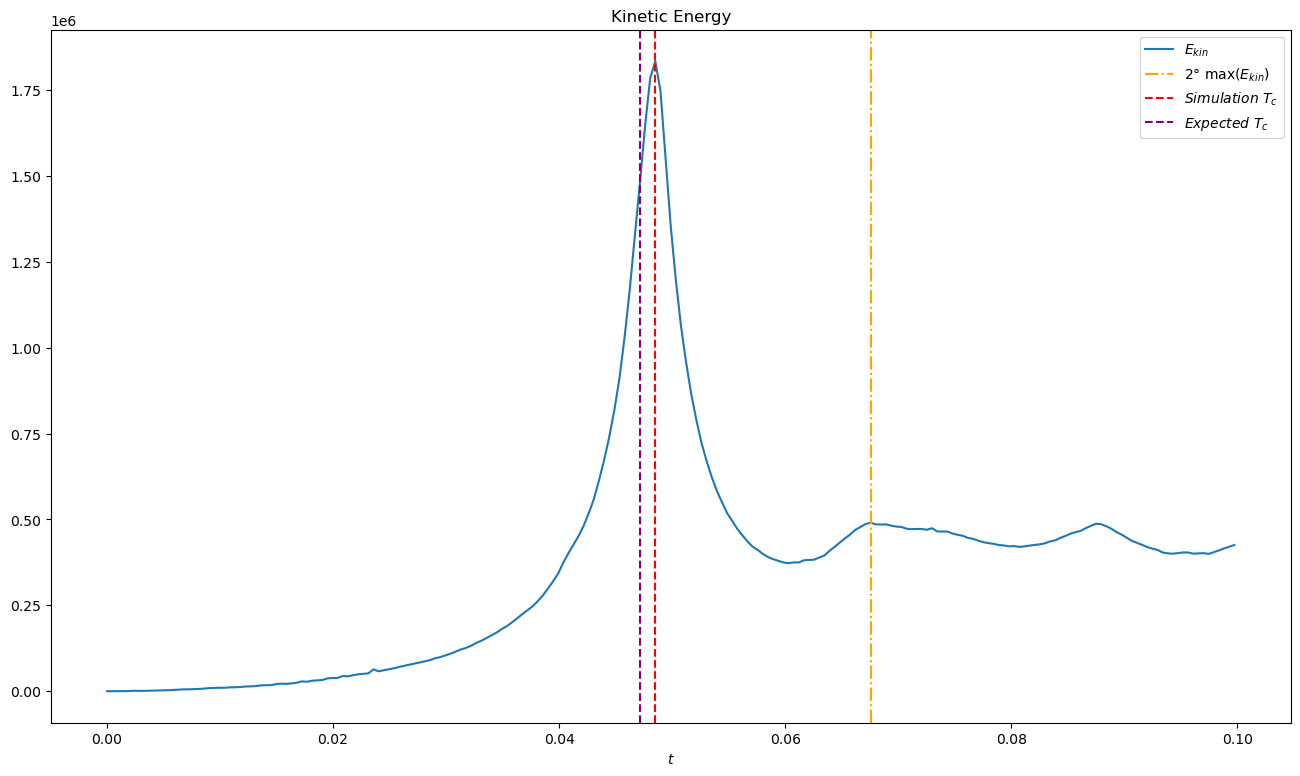

In [335]:
expected_collapse_time = get_collapse_time(get_masses(snapshots, total=True) /
                                           get_sphere_volume(boundary))

print("Expected Collapse time = " + str(expected_collapse_time))
print("Simulation Collpase time = " + str(time_stamp[collapse_index]))
print("Relative Error = " + str(100 * (time_stamp[collapse_index] - expected_collapse_time) /
                                expected_collapse_time) + " %")

fig, ax = plt.subplots(figsize=(16,9))

ax.set_title(title_labels[0])
ax.plot(time_stamp, Energy[Energy_keys[0]], label='$E_{kin}$')
ax.set_xlabel("$t$")

ax.axvline(time_stamp[first_kin_max_index], color='orange', ls='-.', label='$2°\ \max(E_{kin})$')
ax.axvline(time_stamp[collapse_index], color='red', ls='--', label='$Simulation\ T_c$')
ax.axvline(expected_collapse_time, color='purple', ls='--', label='$Expected\ T_c$')

ax.legend()

figures.append(fig)
figures_names.append("kinetic")

plt.show()

In [336]:
# PARTICLES TRAJECTORIES

#--------------------------------------------------------
# Compute the distance from the center of mass for every particle at every time
# Just use the array above (PARTICLE COUNTER) but swap again the idexes
# parti_dist_cm works like this: part_dist_cm[particle_index][time_index]
part_dist_cm = np.swapaxes(particles_distance_cm, 0, 1)

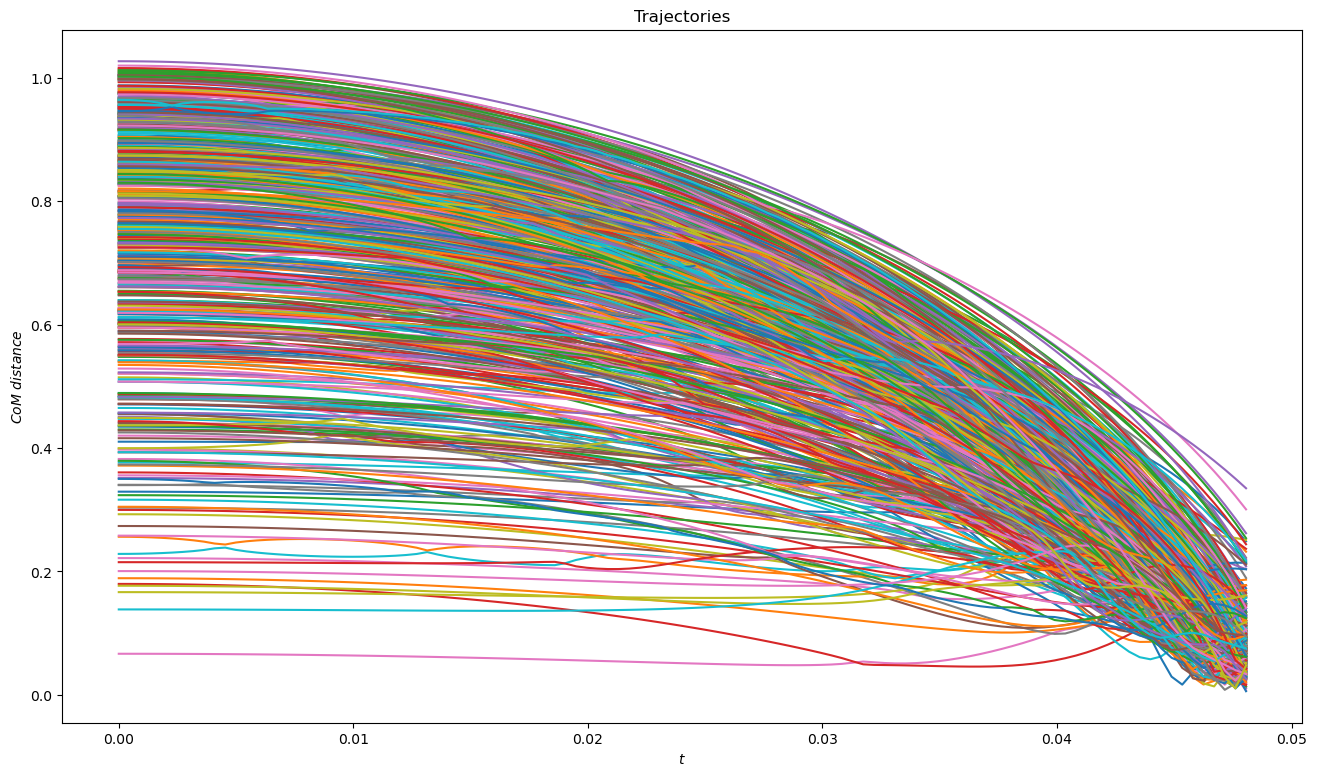

In [337]:
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Trajectories")
ax.set_xlabel("$t$")
ax.set_ylabel("$CoM\ distance$")

for particle_index in range(N):
    ax.plot(time_stamp[:collapse_index], part_dist_cm[particle_index, :collapse_index])

figures.append(fig)
figures_names.append("trajectories")

plt.show()

In [338]:
# CENTER OF MASS OF THE NEW BOUND SYSTEM

#-------------------------------------------------------------
# We want to find the center of mass of the new bound system using get_center_of_mass()
# get_center_of_mass() takes our beloved "snapshots" 4D matrix as input
# We want to create a new "snapshots" variable that contains, at every time, just the particles
# that are bounded (or that we believe they are)

# Use deepcopy() to copy a matrix
# .copy() wouldn't work and you would still modify the original matrix
new_snapshots = copy.deepcopy(snapshots)

# Initialize the new order of particles at every time by
# selecting the indexes of particles that are not bounded
# new_index_order is list of numpy arrays
new_index_order = [np.where(is_particle_bounded[time_index] == False)[0]
                   for time_index in range(len(snapshots))]

# At every time, append to the selected indexes all the remaining ones
for time_index in range(len(snapshots)):
    new_index_order[time_index] = np.append(new_index_order[time_index],
                                            [particle_index for particle_index in range(N)
                                             if particle_index not in new_index_order[time_index]])
    
    # Reorder the particles using the new_index_order
    new_snapshots[time_index][2] = [new_snapshots[time_index][2][particle_index]
                                    for particle_index in new_index_order[time_index]]
    
    # Delete the particles that have positive energy, that now are positioned at the beginning of every snapshot
    del new_snapshots[time_index][2][:N - negative_E_tot_particles[time_index]]

    # Update the number of particles in the new_snapshot at the current time
    new_snapshots[time_index][0] = negative_E_tot_particles[time_index]

# Compute the position of the new center of mass using the the new_snapshots
new_cm_pos = np.array([get_center_of_mass(new_snapshots, time_index, 'pos')
                       for time_index in range(len(new_snapshots))])

In [339]:
# IMAGE SAVER

#------------------------------------------------------------

# Toggle on/off the image saver
save_images = False

if save_images:
    # FOLDERS MANAGING

    #-------------------------------------------------------------------------
    # File paths variables
    images_dir_path = "images"

    # Create folders to store the images
    if not os.path.isdir(images_dir_path):
        os.makedirs(images_dir_path)
    
    # Empty the 'images' folder
    for file_name in os.listdir(images_dir_path):
        file_path = os.path.join(images_dir_path, file_name)
        os.remove(file_path)

    #---------------------------------------------------------------------
    # SAVING IMAGES
    for figure_index in range(len(figures)):
        figures[figure_index].savefig(os.path.join(images_dir_path, figures_names[figure_index]))

In [340]:
# MOVIE MAKER

#------------------------------------------------------------------------

# Toggle on/off the movie maker
make_movie = False

if make_movie:
    # FOLDERS MANAGING

    #-------------------------------------------------------------------------
    # File paths variables
    movie_dir_path = "movie"
    frames_dir_path = os.path.join(movie_dir_path, "frames")
    movie_frame_name_prefix = "snapshot_img_"
    movie_name = "movie.mp4"

    # Create folders to store the movie and its frames
    if not os.path.isdir(movie_dir_path):
        os.makedirs(frames_dir_path)
    
    # Empty the 'frames' folder
    for file_name in os.listdir(frames_dir_path):
        file_path = os.path.join(frames_dir_path, file_name)
        os.remove(file_path)
    
    # Empty the 'movie' folder
    for file_name in os.listdir(movie_dir_path):
        file_path = os.path.join(movie_dir_path, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
    
    #------------------------------------------------------------------------
    # GENERATING FRAMES

    #------------------------------------------------------------------------
    # Rough estimate of the number of frames of the movie
    # Lowering it increases the step between snapshots that are considered
    # Use in a cycle below. If N_frames = len(snapshots) all frames are used
    N_frames = len(snapshots)
    
    # If True, frames will be deleted after the movie has been assembled
    delete_frames = True

    # In order to efficiently plot data with the purpose of making a movie is useful
    # to swap the axis of the array. This is not necessary, but otherwise plotting fucntions
    # would take a lot of time to run
    # "new_pos" works like this: new_pos[time_index][coordinate_index][particle_index]
    # So basically new_pos[time_index][coordinate_index] gives the values of the specified
    # coordinate at the specified time for all particles
    image_pos = np.swapaxes(pos, 0, 1) # Swap particle and time
    image_pos = np.swapaxes(image_pos, 1, 2) # Swap particle and coordinate

    # Initialize a list to store the colors of each particle at any time
    particles_colors = []

    color_bounded = 'dodgerblue'
    color_unbounded = 'orange'
    color_cm = 'red'
    color_new_cm = 'lime'

    # Fill the particles_color list
    for time_index in range(len(snapshots)):
        particles_colors.append([color_bounded if is_inside else color_unbounded
                                 for is_inside in is_particle_bounded[time_index]])

    #-------------------------------------------------------------------------
    # Initialize a 3D plot
    fig = plt.figure(figsize=(16, 9))

    # computed_zorder=False is to allow manual setting of the order of the plots
    ax = fig.add_subplot(projection='3d', computed_zorder=False)
    ax.set_box_aspect(None, zoom=0.9) # To prevent z axis label to be cut off

    # For every snapshot (or for some of them depending of the step of the range() call)
    # plot the positon of every particle in 3D space
    for time_index in range(0, len(snapshots), int(len(snapshots) / N_frames)):
        ax.scatter(image_pos[time_index][0], image_pos[time_index][1], image_pos[time_index][2],
                   color=particles_colors[time_index], zorder=0)
        ax.scatter(cm_pos[time_index][0], cm_pos[time_index][1], cm_pos[time_index][2],
                   color=color_cm, zorder=1)
        ax.scatter(new_cm_pos[time_index][0], new_cm_pos[time_index][1], new_cm_pos[time_index][2],
                   color=color_new_cm, zorder=2)
        
        # For the first snapshot register the axes limit
        if time_index == 0:
            x_lim = ax.get_xlim()
            y_lim = ax.get_ylim()
            z_lim = ax.get_zlim()
        
        # Set e cubic plot for every snapshot and fix the axes limit to the initial ones
        ax.set_aspect('equal', 'datalim')
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_zlim(z_lim)

        # Set the snapshot time stamp as the title of every plot
        ax.set_title("$t=$" + str(round(time_stamp[time_index], 2)))
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_zlabel("$z$")

        # Save the current figure with a proper name
        # zfill() is needed to achieve alphanumerical order later
        frame_name = movie_frame_name_prefix + str(time_index).zfill(5) + ".png"
        frame_path = os.path.join(frames_dir_path, frame_name)
        fig.savefig(frame_path)

        # Clear the axes for the next plot
        ax.clear()

    # Don't show anything
    plt.close()

    #--------------------------------------------------------------------
    # ASSEMBLING FRAMES

    #--------------------------------------------------------------------
    # Get all the files in the frames directory and sort them in alphanumerical order
    movie_img_files = os.listdir(frames_dir_path)
    movie_img_files = sorted(movie_img_files)

    movie_path = os.path.join(movie_dir_path, movie_name)

    # Use the imageio writer to build the movie by appending to it every frame
    # Default fps is 10. 'I' stands for 'multiple images'
    with imageio.get_writer(movie_path, mode='I', fps=10) as writer:
        for filename in movie_img_files:
            image = imageio.imread(os.path.join(frames_dir_path, filename)) # Get the frame
            writer.append_data(image) # Append the frame
    
    # Delete individual frames if requested
    if delete_frames:
        for file_name in os.listdir(frames_dir_path):
            file_path = os.path.join(frames_dir_path, file_name)
            os.remove(file_path)

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_10754/549650090.py:129: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(frames_dir_path, filename)) # Get the frame
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1600, 900) to (1600, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
